In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Step 1: Load Dataset ---
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
print("Dataset path:", path)

Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Dataset path: /kaggle/input/default-of-credit-card-clients-dataset


In [5]:
# Find the file (xls or csv)
file = [f for f in os.listdir(path) if f.endswith('.xls') or f.endswith('.xlsx') or f.endswith('.csv')][0]

if file.endswith(('.xls', '.xlsx')):
    df = pd.read_excel(os.path.join(path, file), header=1)
else:
    df = pd.read_csv(os.path.join(path, file))

print(df)

          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

In [6]:
# Clean columns names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "_")

# Drop ID column if exists
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

print("Columns:", df.columns.tolist())

Columns: ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default_payment_next_month']


In [7]:
# --- Step 2: Split features and target ---
target_col = 'default_payment_next_month'
X = df.drop(columns=[target_col])
y = df[target_col]

# --- Step 3: Preprocessing pipeline ---
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])

X_processed = preprocessor.fit_transform(X)

print(X)
print(y)
print(X_processed)

       limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
0        20000.0    2          2         1   24      2      2     -1     -1   
1       120000.0    2          2         2   26     -1      2      0      0   
2        90000.0    2          2         2   34      0      0      0      0   
3        50000.0    2          2         1   37      0      0      0      0   
4        50000.0    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995   220000.0    1          3         1   39      0      0      0      0   
29996   150000.0    1          3         2   43     -1     -1     -1     -1   
29997    30000.0    1          2         2   37      4      3      2     -1   
29998    80000.0    1          3         1   41      1     -1      0      0   
29999    50000.0    1          2         1   46      0      0      0      0   

       pay_5  ...  bill_amt3  bill_amt4  bill_amt5 

In [8]:
# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 5: Apply SMOTE to training data ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE:  {np.bincount(y_train_resampled)}")

Before SMOTE: [18691  5309]
After SMOTE:  [18691 18691]


In [9]:
# --- Step 6: Define evaluation function ---
def evaluate_model(y_test, y_pred, y_proba, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(rec_curve, prec_curve)
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.tight_layout()
    plt.show()


XGBoost Performance:
Accuracy:  0.8002
Precision: 0.5653
Recall:    0.4175
F1-score:  0.4803
AUC:       0.7539
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.57      0.42      0.48      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.66      0.68      6000
weighted avg       0.78      0.80      0.79      6000



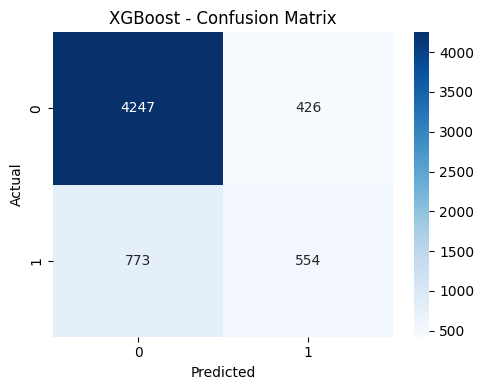

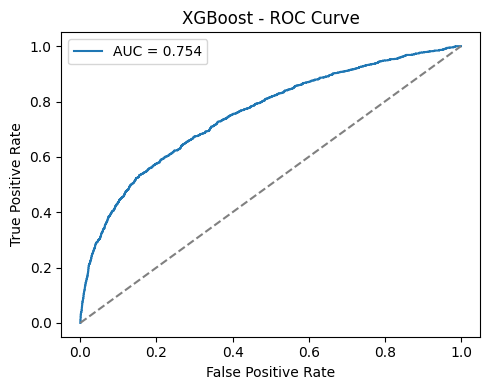

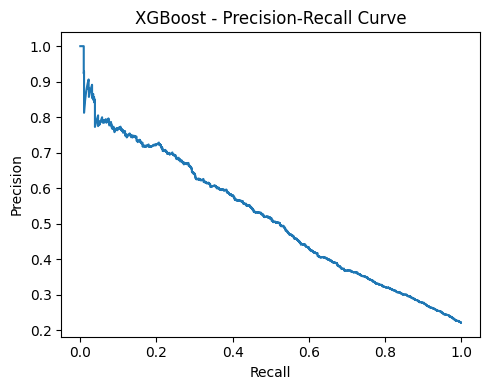

In [10]:
# --- Step 7: Train and evaluate XGBoost ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, xgb_pred, xgb_proba, "XGBoost")

[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Performance:
Accuracy:  0.8090
Precision: 0.5917
Recall:    0.4401
F1-score:  0.5048
AUC:       0.7674
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.59      0.44      0.50      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000



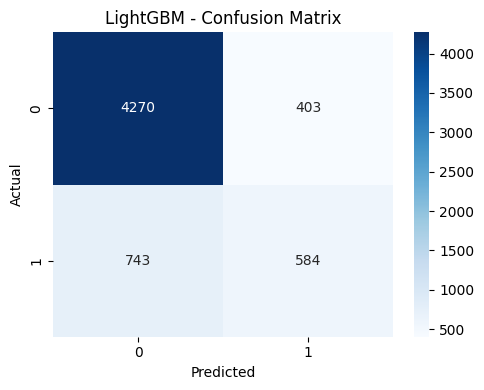

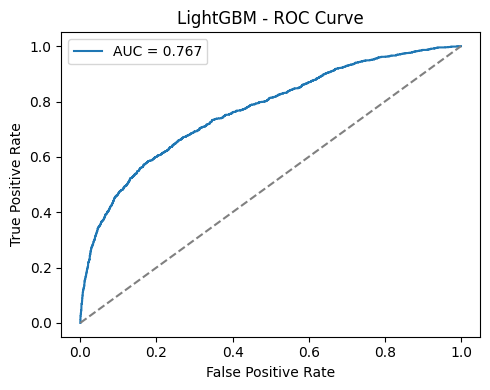

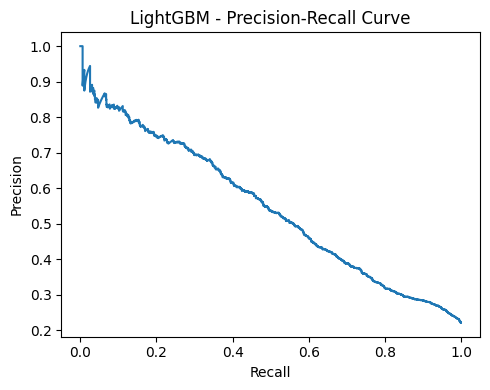

In [11]:
# --- Step 8: Train and evaluate LightGBM ---
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)
lgbm_pred = lgbm_model.predict(X_test)
lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, lgbm_pred, lgbm_proba, "LightGBM")


CatBoost Performance:
Accuracy:  0.8125
Precision: 0.6194
Recall:    0.3949
F1-score:  0.4823
AUC:       0.7682
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      4673
           1       0.62      0.39      0.48      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.80      6000



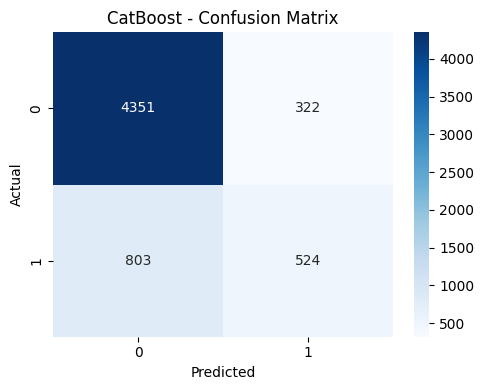

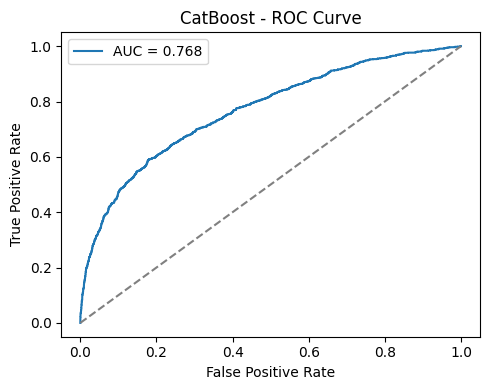

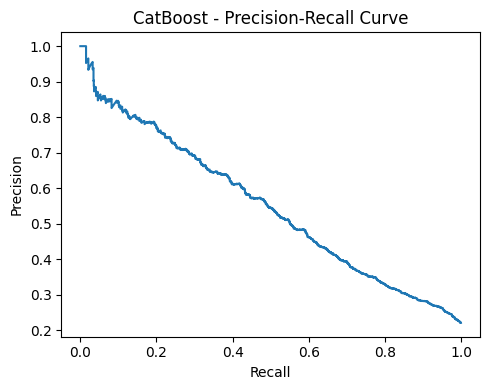

In [12]:
# --- Step 9: Train and evaluate CatBoost ---
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train_resampled, y_train_resampled)
cat_pred = cat_model.predict(X_test)
cat_proba = cat_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, cat_pred, cat_proba, "CatBoost")

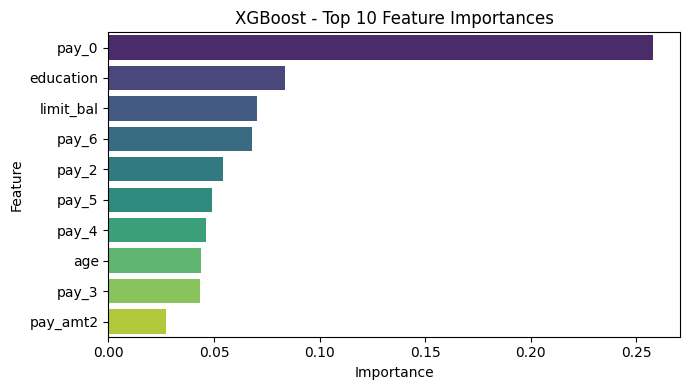

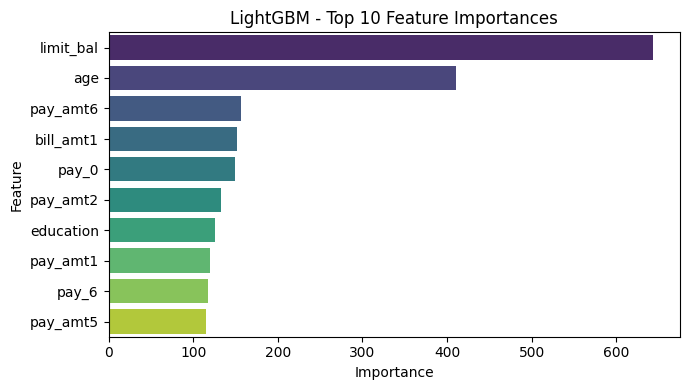

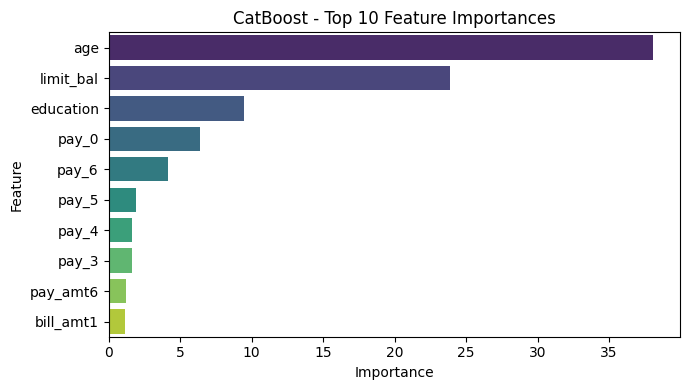

In [13]:
# --- Step 10: Feature importance plots ---
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(10)

    plt.figure(figsize=(7, 4))
    sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
    plt.title(f'{model_name} - Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

# Original feature names after preprocessing (num_cols)
plot_feature_importance(xgb_model, num_cols, "XGBoost")
plot_feature_importance(lgbm_model, num_cols, "LightGBM")
plot_feature_importance(cat_model, num_cols, "CatBoost")